This is normal SNN network without stashing

In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
import copy
from scipy.stats import skew
import random

In [2]:
def seed_all(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
seed_all(42)

In [3]:
# Hyperparameters
batch_size = 128
epochs = 3
beta = 0.95
# The beta defined here = (1 - delta(t)/Tau)
# Here delta(t) is the clk period
# Tau = Time constant = RC
# This is the approximation of beta = exp(-delta(t)/Tau)
num_steps = 25

In [4]:
# Perform learning over cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST("./../data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST("./../data", train=False, download=True, transform=transform)

In [6]:
# Loading the training and test data
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
# Here we are creating a single hidden layer NN, with 150 nodes
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(784, 150, bias=False)
        self.lif1 = snn.Leaky(beta=beta,reset_mechanism= "zero")
        self.fc2 = nn.Linear(150, 10, bias=False)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)


In [8]:
next(net.parameters()).is_cuda

True

In [9]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [10]:
def accuracy():
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, label in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            label = label.to(device)

            # Test set forward pass
            test_spk, test_mem = net(images.view(batch_size, -1))
            n_samples += label.size(0)
            _, idx = test_spk.sum(dim=0).max(1)
            n_correct+= (label == idx).sum().item()
            return(n_correct/n_samples * 100)

In [11]:
%%time
accuracy_plot = []
n_total_steps = len(train_loader)
for epoch_iter in range(epochs):
    for i,(data, target) in enumerate(train_loader):
        x = data.to(device)
        y = target.to(device)
        spk_rec, mem_rec = net(x.view(batch_size, -1))
        loss_val = torch.zeros((1),device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], y)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if((i+1) % 30 == 0):
            accuracy_plot.append(accuracy())
        if (i+1) % 100 == 0:
             print (f'Epoch [{epoch_iter+1}/{epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss_val.item():.4f}')

        

Epoch [1/3], Step[100/468], Loss: 15.3867
Epoch [1/3], Step[200/468], Loss: 7.9441
Epoch [1/3], Step[300/468], Loss: 8.4975
Epoch [1/3], Step[400/468], Loss: 9.4965
Epoch [2/3], Step[100/468], Loss: 7.7095
Epoch [2/3], Step[200/468], Loss: 12.9007
Epoch [2/3], Step[300/468], Loss: 5.3362
Epoch [2/3], Step[400/468], Loss: 5.1104
Epoch [3/3], Step[100/468], Loss: 6.3603
Epoch [3/3], Step[200/468], Loss: 11.2323
Epoch [3/3], Step[300/468], Loss: 8.0277
Epoch [3/3], Step[400/468], Loss: 5.9627
CPU times: user 1min 10s, sys: 201 ms, total: 1min 10s
Wall time: 1min 10s


In [12]:
print(accuracy())
accuracy_plot.append(accuracy())

95.3125


Text(0, 0.5, 'Accuracy')

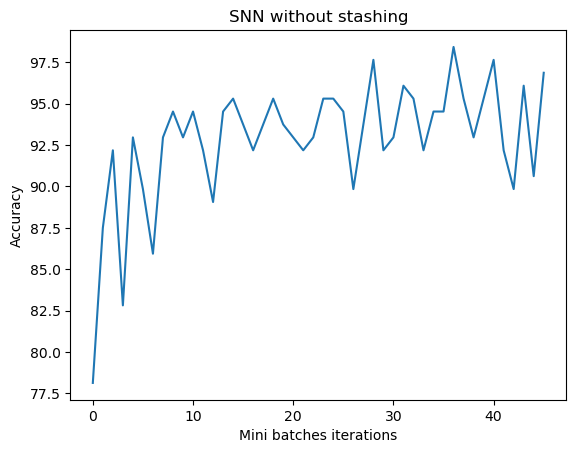

In [13]:
plt.plot(accuracy_plot)
plt.title("SNN without stashing")
plt.xlabel("Mini batches iterations")
plt.ylabel("Accuracy")


In [14]:
# torch.save(net, 'SNN_without_stashing.pt')

In [15]:
# #Creating computational graph to see, whether all the neurons are contributing or not
# batch = next(iter(train_loader))
# yhat = net(batch[0].reshape(-1,28*28).to(device)) # Give dummy batch to forward().

# from torchviz import make_dot

# make_dot(yhat, params=dict(list(net.named_parameters()))).render("trial_1", format="png")